In [2]:
# https://github.com/GeospatialGeeks/Satellite-Image-Building-Segmentation
# mount drive, turn on GPU runtime
%load_ext autoreload
%autoreload 2
%matplotlib inline
import PIL, os, mimetypes
from fastai.vision import *
from fastai.utils.collect_env import *
Path.ls = lambda x: list(x.iterdir())
show_install(True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.1+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Thu Jul 16 09:28:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-----------------

In [3]:
imgsdir = Path('/content/fastai/segbldg/data/images')
imgsname = get_image_files(imgsdir)
lblsdir = Path('/content/fastai/segbldg/data/labels')
lblsname = get_image_files(imgsdir)
get_y_fn = lambda x:lblsdir/f'{x.stem}{x.suffix}'


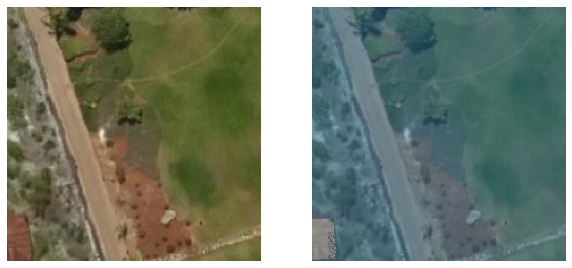

In [4]:
testindex = 2
imgtest = open_image(imgsname[testindex])
lbltest = open_mask(get_y_fn(imgsname[testindex]), div=True)
fig,ax = plt.subplots(1,2, figsize=(10,10))
imgtest.show(ax=ax[0], alpha=0.2)
imgtest.show(ax=ax[1], y=lbltest, cmap='binary', alpha=0.4)

In [5]:
IMGSHAPE = np.array(lbltest.shape[1:])
BS = 8

class lbllist(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)
    
class imglist(ImageImageList):
    _label_cls = lbllist

tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.2)    

data = (imglist.from_folder(imgsdir)
      .random_split_by_pct()
      .label_from_func(get_y_fn, classes=['0', '1'])
      .transform(tfms, size=IMGSHAPE, tfm_y=True)
      .databunch(bs=BS)
      .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


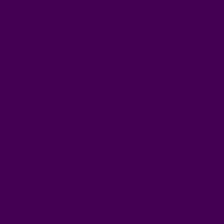

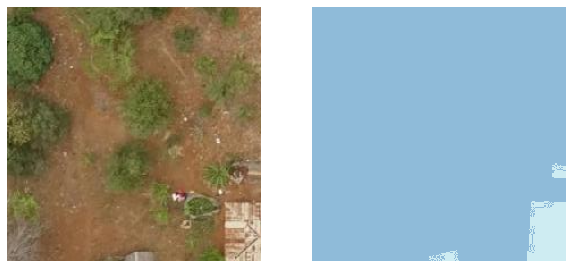

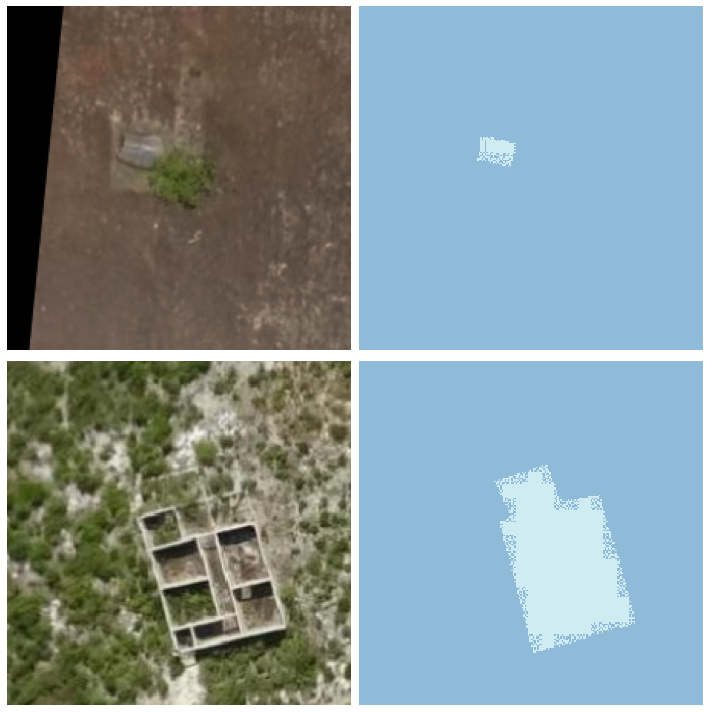

In [6]:
_,ax = plt.subplots(1,2,figsize=(10,10))
data.valid_ds.x[2].show(ax=ax[0])
data.valid_ds.y[2].show(ax=ax[1])
data.show_batch(2, figsize=(10,10))
data.train_ds.y[2].data
data.train_ds.y[2]

In [7]:
def dice_loss(h, y):
    smooth = 1.
    hflat = h[:,1,None].sigmoid().contiguous().view(-1).float()
    yflat = y.view(-1).float()
    union = (hflat * yflat).sum()
    return 1-( (2.*union+smooth)/((hflat+yflat).sum()+smooth) )

def combo_loss(h, y):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(h,y) + dice_loss(h,y)
# combo_loss(data.train_ds.y[2], data.train_ds.y[2])

def acc_fixed(h,y):
    y=y.squeeze(1).view(y.shape[0],-1)
    h=h.argmax(dim=1).view(y.shape[0],-1)
    return (y==h).float().mean()

def acc_thresh(h,y,thresh=0.5, sigmoid=True):
    if sigmoid:
        h=h.sigmoid()
    h=h.argmax(dim=1).view(h.shape[0],-1)
    y=y.view(h.shape[0], -1)
    return ((h>thresh)==target.byte()).float().mean()
metrics = [dice_loss, accuracy_thresh, dice]

learn = unet_learner(data, models.resnet34, loss_func=combo_loss, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


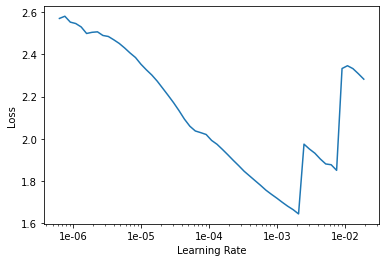

In [9]:
learn.recorder.plot()

In [10]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [ ]:
lr = 1e-3
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-512-best')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.440357,0.374847,0.223707,0.935748,0.714084,11:02
1,0.363568,0.344520,0.201871,0.948344,0.727169,10:57
2,0.342038,0.321333,0.191129,0.951277,0.736363,10:52
3,0.305161,0.288290,0.171521,0.954358,0.757298,10:53
4,0.279345,0.283398,0.168185,0.955402,0.758213,10:44


Better model found at epoch 0 with dice value: 0.714083731174469.
Better model found at epoch 1 with dice value: 0.7271689176559448.
Better model found at epoch 2 with dice value: 0.7363632917404175.
Better model found at epoch 3 with dice value: 0.7572981119155884.
Better model found at epoch 4 with dice value: 0.7582128643989563.


In [14]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


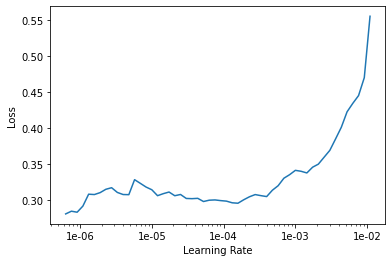

In [15]:
learn.recorder.plot()

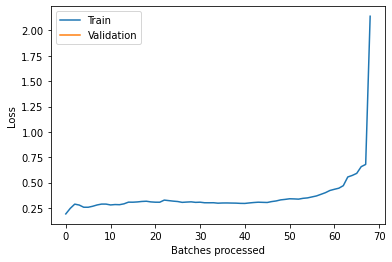

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [18]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

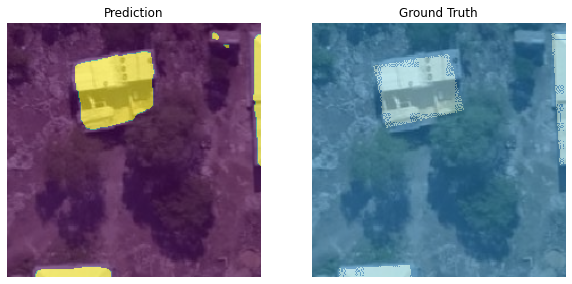

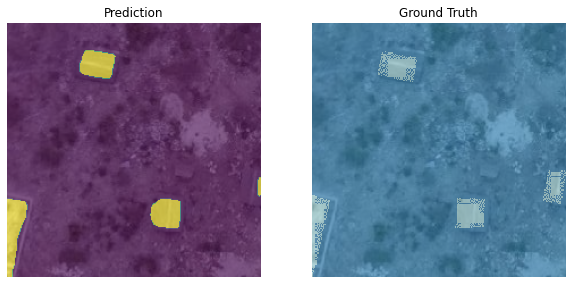

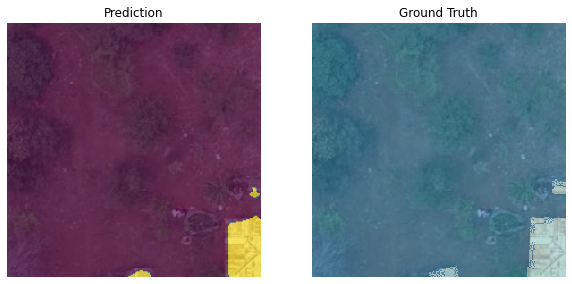

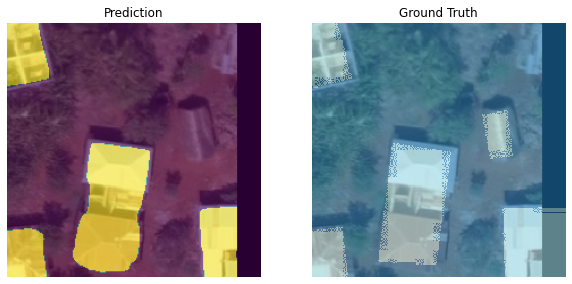

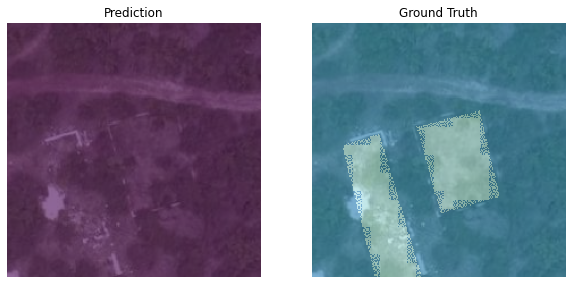

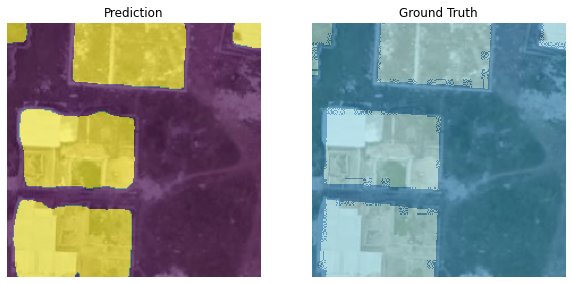

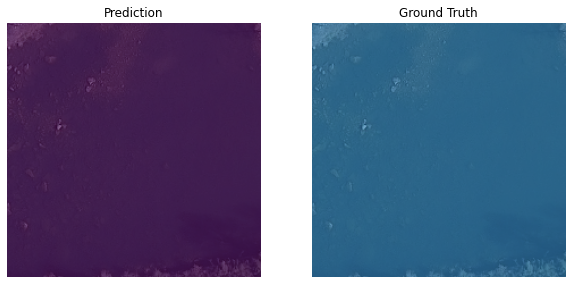

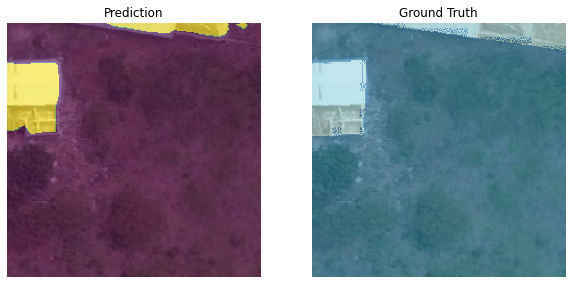

In [21]:
for i in range(BS):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.95)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [22]:
testimg=open_image('test.png')
t_img = Image(pil2tensor(testimg,np.float32))
output = learn.predict(t_img)
im = (outputs[2][1]).numpy()

ValueError: axes don't match array

In [25]:
Image(pil2tensor(testimg,np.float32))

ValueError: axes don't match array

In [26]:
pil2tensor(testimg,np.float32)

ValueError: axes don't match array